# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import contextlib
import io
import gc
from abc import ABC, abstractmethod
import os
import pandas as pd
import time
import shutil
from google.colab import files

np.random.seed(42)

In [2]:
# Variables initialization
ETA_ = 1 # Risk aversion parameter
EPSILON = 1e-5 # Stopping criteria threshold
MAX_ITER = int(1/EPSILON)
NUM_EXEC = 100

# Utilities

In [3]:
!mkdir FTSE100
!mkdir EUROSTOXX50
!mkdir FTSE_MIB
path = "/content/"

mkdir: cannot create directory ‘FTSE100’: File exists
mkdir: cannot create directory ‘EUROSTOXX50’: File exists
mkdir: cannot create directory ‘FTSE_MIB’: File exists


In [4]:
def import_dataset(name):
  """
  This function import the dataset given the relative name

  Args:
    - name: name of the dataset, 3 availables

  Returns:
    - r:
    - sigma: Covariance matrix
    - n: number of asset """
  if name == "FTSE_MIB":
    # Import the matrix of the returs of the assets from the file RR_FtseMib.txt
    asset_returns = np.loadtxt(path+'RR_FtseMib.txt')

    # Save the number of assets
    n = asset_returns.shape[1]

    # Mean of the weekly return of the assets
    r = np.mean(asset_returns, axis=0)

    # Covariance matrix of the returns of the assets
    sigma = np.cov(asset_returns, rowvar=False)

    return r, sigma, n

  elif name == "EUROSTOXX50":
    # Import the matrix of the returs of the assets from the file RR_FtseMib.txt
    asset_returns = np.loadtxt(path+'RR_Stoxx50.txt')

    # Save the number of assets
    n = asset_returns.shape[1]

    # Mean of the weekly return of the assets
    r = np.mean(asset_returns, axis=0)

    # Covariance matrix of the returns of the assets
    sigma = np.cov(asset_returns, rowvar=False)

    return r, sigma, n

  elif name == "FTSE100":
    # Import the matrix of the returs of the assets from the file RR_FtseMib.txt
    asset_returns = np.loadtxt(path+'RR_Ftse100.txt')

    # Save the number of assets
    n = asset_returns.shape[1]

    # Mean of the weekly return of the assets
    r = np.mean(asset_returns, axis=0)

    # Covariance matrix of the returns of the assets
    sigma = np.cov(asset_returns, rowvar=False)

    return r, sigma, n

  else:
    return "No correct name given"

In [5]:
class Utilities:
  @staticmethod
  def print_weights(weights):
    """
    This is an utility function that allow the user to print the asset with its relative percentage.

    Args:
      - weights (np.array): weights of the assets
    Return:
      - None
    """
    print("Weights per asset after convergence:")
    for i, w in enumerate(weights):
      if w != 0:
        print(f"Asset {i + 1}: {np.round(w * 100, 2)}%")


  @staticmethod
  def plot_function(values, y_string_label, title, values_2=None, legend_labels = None):
    """
    This function plots the trend of the given values.

    Args:
      - values (np.array): Values that need to be plotted.
      - y_string_label (string): Label of the y-axis.
      - title (string): Title of the plot.
      - values_2 (np.array, optional): Second set of values to be plotted (Default = None).
      - legend (np.array, optional): Legend of the different Series (Default = None).

    Returns:
      - plt
    """
    plt.plot(values[:50], label=legend_labels[0] if legend_labels else None)
    plt.ylabel(y_string_label)

    if values_2 is not None:
        plt.plot(values_2[:50], label=legend_labels[1] if legend_labels else None)
        plt.legend()

    plt.xlabel("Iterations")
    plt.title(title)
    #plt.show()
    return plt

  @staticmethod
  def plot_assets_pie(weights):
    """
    This function plot the asset obtained weights in a pie chart.
    Args:
      - weights (np.array): weights of the different assets
    Return:
      - None
    """
    labels = [f"Asset {w+1}" for w in range(0, len(weights))]
    # Filter out the 0 values from weights and adjust labels accordingly
    filtered_labels = [label for label, weight in zip(labels, weights) if weight != 0]
    filtered_weights = [weight for weight in weights if weight != 0]

    # Plot the pie chart
    plt.pie(filtered_weights, labels=filtered_labels, autopct='%1.2f%%')
    plt.title('Asset allocation after convergence')
    plt.show()


In [6]:
class OptimizationBaseClass(ABC):
    def __init__(self):
      self.utils = Utilities()

    @abstractmethod
    def __call__(self):
        pass


    def line_search(self,dk, xk, sigma, r, eta, min_gamma=0, max_gamma=1, n_step=100):
        """
        Line search to find the optimal step size gamma in the range (min_gamma, max_gamma].

        Args:
        fun (function): The objective function to minimize.
        dk (np.ndarray): The direction of descent.
        xk (np.ndarray): The current point.
        min_gamma (float): The minimum step size to consider.
        max_gamma (float): The maximum step size to consider.
        n_step (int): Number of steps to divide the interval.

        Returns:
        gamma (float): The optimal step size.
        """
        gamma_values = np.linspace(min_gamma, max_gamma, n_step)
        best_gamma = min_gamma
        best_value = float('inf')

        for gamma in gamma_values:
            candidate_point = xk + gamma * dk
            candidate_value = self.f(x=candidate_point,sigma=sigma, r=r, eta=eta)

            if candidate_value < best_value:
                best_value = candidate_value
                best_gamma = gamma

        return best_gamma

    @staticmethod
    def f(x, sigma, r, eta):
        """
        This function computes the cost function
        """
        p_variance = x.T @ sigma @ x
        p_return = r.T @ x
        return eta * p_variance - p_return

    @staticmethod
    def gradient(x, sigma, r, eta):
        """
        This function computes the gradient of the cost function
        """
        p_variance_grad = 2 * (sigma @ x)
        return eta * p_variance_grad - r

    @staticmethod
    def LMO(grad):
        """
        Linear Minimization Oracle (LMO) for the Frank-Wolfe algorithm on a simplex.

        Args:
          - grad (np.array): gradient of the objective function at the current point
        Return:
          - A 1D numpy array that represents the vertex of the simplex corresponding to the direction
              of steepest descent.
        """
        j = np.argmin(grad)
        s = np.zeros_like(grad)
        s[j] = 1
        return s

    @staticmethod
    def diminishing_step_size(k):
        """
        Calculate the diminishing step size for the Frank-Wolfe algorithm.

        Args:
        - k (int): The current iteration index.

        Returns:
        - gamma (float): The step size, calculated as 2/(k + 2).
        """
        return 2 / (k + 2)

    @staticmethod
    def simplex_projection(y, a=1):
        """
        Projects a given vector onto the simplex with a specified target sum.

        Args:
        - y (np.ndarray): The input vector to be projected onto the simplex.
        - a (float): The target sum for the simplex projection (Default = 1).

        Returns:
        - x (np.ndarray): The projected vector that satisfies the simplex constraints.
        """

        n = len(y)
        u = np.sort(y)[::-1]
        cumulative_sum = np.cumsum(u) - a
        K = np.max(np.where(cumulative_sum / np.arange(1, n + 1) < u)[0])
        tau = (cumulative_sum[K]) / (K + 1)
        x = np.maximum(y - tau, 0)

        return x

    @staticmethod
    def optimized_simplex_projector(y, a=1):
        """
        Implementation of the simplex projection algorithm from page 580 of the referenced paper.

        Args:
        y (np.ndarray): Input vector.
        a (float): Target sum for the simplex projection (default = 1).

        Returns:
        np.ndarray: Projected vector.
        """

        v = [y[0]]
        v_tilde = []
        rho = y[0] - a

        for n in range(1, len(y)):
            if y[n] > rho:
                rho = rho + (y[n] - rho) / (len(v) + 1)
                if rho > y[n] - a:
                    v.append(y[n])
                else:
                    v_tilde.extend(v)
                    v = [y[n]]
                    rho = y[n] - a

        if v_tilde:
            for y_t in v_tilde:
                if y_t > rho:
                    v.append(y_t)
                    rho = rho + (y_t - rho) / len(v)

        while True:
            v_old_len = len(v)
            v = [y_t for y_t in v if y_t > rho]
            if len(v) == v_old_len:
                break
            rho = (np.sum(v) - a) / len(v)

        tau = rho
        x = np.maximum(y - tau, 0)

        return x

    def print_weights(self, weights):
      return self.utils.print_weights(weights)

    def plot_function(self, values, y_string_label, title, values_2, legend_labels):
      return self.utils.plot_function(values, y_string_label, title, values_2, legend_labels)

    def plot_assets_pie(self, weights):
      return self.utils.plot_assets_pie(weights)


In [7]:
def test_optimized_proj():
    w, i, g_val, f_val =  projected_gradient_method(n, r, sigma, eta, projection_method=1,MAX_ITER=MAX_ITER,EPSILON=EPSILON)

def test_simple_proj():
    w, i, g_val, f_val =  projected_gradient_method(n, r, sigma, eta, projection_method=0,MAX_ITER=MAX_ITER,EPSILON=EPSILON)

def plot_two_algorithms(values_fw, values_asfw, y_string_label, title):
    """
    This function plots the trend of the given values for three different algorithms.

    Args:
      - values_fw (np.array): Values for the Frank-Wolfe algorithm.
      - values_asfw (np.array): Values for the Away-Step Frank-Wolfe algorithm.
      - y_string_label (string): Label for the y-axis.
      - title (string): Title of the plot.

    Returns:
      - None
    """
    plt.figure(figsize=(10, 6))

    # Plot each set of values with different labels and colors
    plt.plot(values_fw[:3], label='Frank-Wolfe', color='g', linestyle='--')
    plt.plot(values_asfw[:3], label='Away-Step Frank-Wolfe', color='r', linestyle='-.')

    # Set logarithmic scale for the y-axis
    plt.yscale('log')

    # Set plot labels and title
    plt.ylabel(y_string_label)
    plt.xlabel("Iterations")
    plt.title(title)

    # Improved legend placement
    plt.legend(loc='upper right', frameon=True, fontsize='medium')

    # Show the plot
    plt.show()
#plot_two_algorithms(dg_values_fw_ls, dg_values_as_fw, "Duality Gap", "FTSE_MIB Duality Gap convergence")

In [8]:
def pipeline(datasets=["FTSE100", "EUROSTOXX50", "FTSE_MIB"], num_runs=1,eta=1):
    results = []  # List to store results for creating a DataFrame

    s = time.time()
    for d in datasets:
        r, sigma, n = import_dataset(d)
        print(f"Processing dataset {d}")

        # Projected Gradient Method
        print('---> Projected Gradient Method')
        projected_gradient_method = ProjectedGradient()

        for projection_method in [0, 1]:  # Loop over both projection methods
            for step_size in ["diminishing", "line_search"]:
                total_time = 0.0
                x_accum = None
                iteration_accum = []
                dg_values_accum = []
                f_values_accum = []

                print(f'------> with step size "{step_size}" and projection method "{projection_method}"')
                for _ in range(num_runs):
                    start_time = time.time()
                    # Call the projected gradient method
                    w, _, dg_values, f_values, iteration = projected_gradient_method(
                        n=n, r=r, sigma=sigma, eta=eta, MAX_ITER=MAX_ITER, EPSILON=EPSILON,
                        s=130, projection_method=projection_method, step_size=step_size
                    )
                    end_time = time.time()
                    total_time += (end_time - start_time)

                    # Accumulate results
                    if x_accum is None:
                        x_accum = np.array(w)  # Initialize with the first result
                    else:
                        x_accum += np.array(w)  # Accumulate weights

                    iteration_accum.append(iteration)
                    dg_values_accum.append(dg_values)
                    f_values_accum.append(f_values)

                # Compute averages
                avg_time = total_time / num_runs
                avg_x = x_accum / num_runs
                avg_iteration = np.mean(iteration_accum)
                avg_dg_values = np.mean(dg_values_accum, axis=0)
                avg_f_values = np.mean(f_values_accum, axis=0)

                results.append({
                    "Dataset": d,
                    "Method": "Projected Gradient",
                    "Step Size": step_size,
                    "Projection Method": projection_method,
                    "Average Time": avg_time,
                    "Average x": avg_x,
                    "Average Iteration": avg_iteration,
                    "Average Gradient Mapping": avg_dg_values,
                    "Average Objective Function Values": avg_f_values
                })

        # Frank-Wolfe Method
        print('---> Frank-Wolfe Method')
        frank_wolfe_method = FrankWolfe()

        for step_size in ["line_search", "diminishing"]:
            total_time = 0.0
            x_accum = None
            iteration_accum = []
            dg_values_accum = []
            f_values_accum = []

            print(f'------> with step size "{step_size}"')
            for _ in range(num_runs):
                start_time = time.time()
                # Call the Frank-Wolfe method
                w, _, dg_values, f_values, iteration = frank_wolfe_method(
                    n=n, r=r, sigma=sigma, eta=eta, step_size=step_size,
                    MAX_ITER=MAX_ITER, EPSILON=EPSILON
                )
                end_time = time.time()
                total_time += (end_time - start_time)

                # Accumulate results
                if x_accum is None:
                    x_accum = np.array(w)
                else:
                    x_accum += np.array(w)

                iteration_accum.append(iteration)
                dg_values_accum.append(dg_values)
                f_values_accum.append(f_values)

            # Compute averages
            avg_time = total_time / num_runs
            avg_x = x_accum / num_runs
            avg_iteration = np.mean(iteration_accum)
            avg_dg_values = np.mean(dg_values_accum, axis=0)
            avg_f_values = np.mean(f_values_accum, axis=0)

            results.append({
                "Dataset": d,
                "Method": "Frank-Wolfe",
                "Step Size": step_size,
                "Projection Method": None,
                "Average Time": avg_time,
                "Average x": avg_x,
                "Average Iteration": avg_iteration,
                "Average Gradient Mapping": avg_dg_values,
                "Average Objective Function Values": avg_f_values
            })

        # Away-Step Frank-Wolfe Method
        print('---> Away-Step Frank-Wolfe Method')
        away_step_frank_wolfe_method = FrankWolfeAwayStep()

        print('------> with step size "line_search"')
        total_time = 0.0
        x_accum = None
        iteration_accum = []
        dg_values_accum = []
        f_values_accum = []

        for _ in range(num_runs):
            start_time = time.time()
            # Call the Away-Step Frank-Wolfe method
            w, _, dg_values, f_values, iteration = away_step_frank_wolfe_method(
                n=n, r=r, sigma=sigma, eta=eta, EPSILON=EPSILON,
                MAX_ITER=MAX_ITER, step_size="line_search"
            )
            end_time = time.time()
            total_time += (end_time - start_time)

            # Accumulate results
            if x_accum is None:
                x_accum = np.array(w)
            else:
                x_accum += np.array(w)

            iteration_accum.append(iteration)
            dg_values_accum.append(dg_values)
            f_values_accum.append(f_values)

        # Compute averages
        avg_time = total_time / num_runs
        avg_x = x_accum / num_runs
        avg_iteration = np.mean(iteration_accum)
        avg_dg_values = np.mean(dg_values_accum, axis=0)
        avg_f_values = np.mean(f_values_accum, axis=0)

        results.append({
            "Dataset": d,
            "Method": "Away-Step Frank-Wolfe",
            "Step Size": "line_search",
            "Projection Method": None,
            "Average Time": avg_time,
            "Average x": avg_x,
            "Average Iteration": avg_iteration,
            "Average Gradient Mapping": avg_dg_values,
            "Average Objective Function Values": avg_f_values
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    e = time.time()
    print("Overall time", e - s)

    return results_df


def plot_three_algorithms(values_pg, values_fw, values_asfw, y_string_label, title):
    """
    This function plots the trend of the given values for three different algorithms.

    Args:
      - values_pg (np.array): Values for the Projected Gradient algorithm.
      - values_fw (np.array): Values for the Frank-Wolfe algorithm.
      - values_asfw (np.array): Values for the Away-Step Frank-Wolfe algorithm.
      - y_string_label (string): Label for the y-axis.
      - title (string): Title of the plot.

    Returns:
      - None
    """
    plt.figure(figsize=(10, 6))

    # Plot each set of values with different labels and colors
    plt.plot(values_pg[:30], label='Projected Gradient', color='b', linestyle='-')
    plt.plot(values_fw[:30], label='Frank-Wolfe', color='g', linestyle='--')
    plt.plot(values_asfw[:30], label='Away-Step Frank-Wolfe', color='r', linestyle='-.')

    # Set plot labels and title
    plt.ylabel(y_string_label)
    plt.xlabel("Iterations")
    plt.title(title)

    # Improved legend placement
    plt.legend(loc='upper right', frameon=True, fontsize='medium')

    # Show the plot
    plt.show()

    return plt


def plot_pipeline_results(results_df, datasets=["FTSE100", "EUROSTOXX50", "FTSE_MIB"]):
  """
  This function save as png the results of the dataframe obtained from the pipeline.
  Args:
    -results_df (Dataframe): The dataframe that gets out of the pipeline containing the results
    -datasets (Array): List of all the datasets
  Return:
    -None
  """
  # Initialize Objects
  ut = Utilities()
  for ds in datasets:
    print("Processing: ", ds)
    ################# PROJECTED GRADIENT ######################
    # Projected Gradient Obj func method 0
    obj_f_val_ls_0 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Projection Method'] == 0)]["Average Objective Function Values"].values[0] # Obj val Proj Grad Line search method = 0
    obj_f_val_d_0 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'diminishing') & (results_df['Projection Method'] == 0)]["Average Objective Function Values"].values[0] # Obj val Proj Grad Diminish method = 0
    plt = ut.plot_function(obj_f_val_ls_0, y_string_label='Objective function values', title='Convergence of the objective function', values_2 = obj_f_val_d_0, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "proj_grad_0_obj_func.png"))
    plt.close()
    # Projected Gradient Obj func method 1
    obj_f_val_ls_1 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Projection Method'] == 1)]["Average Objective Function Values"].values[0] # Obj val Proj Grad Line search method = 1
    obj_f_val_d_1 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'diminishing') & (results_df['Projection Method'] == 1)]["Average Objective Function Values"].values[0] # Obj val Proj Grad Diminish method = 1
    plt = ut.plot_function(obj_f_val_ls_1, y_string_label='Objective function values', title='Convergence of the objective function', values_2 = obj_f_val_d_1, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "proj_grad_1_obj_func.png"))
    plt.close()
    # Projected Gradient Grad map method 0
    grad_map_val_ls_0 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Projection Method'] == 0)]["Average Gradient Mapping"].values[0]
    grad_map_val_d_0 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'diminishing') & (results_df['Projection Method'] == 0)]["Average Gradient Mapping"].values[0]
    plt = ut.plot_function(grad_map_val_ls_0, y_string_label='Gradient mapping values', title='Convergence of the Gradient mapping values', values_2 = grad_map_val_d_0, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "proj_grad_0_grad_map.png"))
    plt.close()
    # Projected Gradient Grad map method 1
    grad_map_val_ls_1 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Projection Method'] == 1)]["Average Gradient Mapping"].values[0]
    grad_map_val_d_1 = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'diminishing') & (results_df['Projection Method'] == 1)]["Average Gradient Mapping"].values[0]
    plt = ut.plot_function(grad_map_val_ls_1, y_string_label='Gradient mapping values', title='Convergence of the Gradient mapping values', values_2 = grad_map_val_d_1, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "proj_grad_1_grad_map.png"))
    plt.close()
    ################# FRANK-WOLFE ######################
    # FW Obj func
    obj_f_fw_ls = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Method'] == "Frank-Wolfe")]["Average Objective Function Values"].values[0]
    obj_f_fw_d = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'diminishing') & (results_df['Method'] == "Frank-Wolfe")]["Average Objective Function Values"].values[0]
    plt = ut.plot_function(obj_f_fw_ls, y_string_label='Objective function values', title='Convergence of the objective function', values_2 = obj_f_fw_d, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "fw_obj_func.png"))
    plt.close()
    # FW Duality Gap
    dg_fw_ls = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Method'] == "Frank-Wolfe")]["Average Gradient Mapping"].values[0]
    dg_fw_d = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'diminishing') & (results_df['Method'] == "Frank-Wolfe")]["Average Gradient Mapping"].values[0]
    plt = ut.plot_function(dg_fw_ls, y_string_label='Duality Gap values', title='Convergence of the duality gap', values_2 = dg_fw_d, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "fw_dual_gap.png"))
    ################# AWAY-STEPS FRANK-WOLFE ######################
    # AS FW Obj func
    obj_f_as_fw_ls = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Method'] == "Away-Step Frank-Wolfe")]["Average Objective Function Values"].values[0]
    plt = ut.plot_function(obj_f_fw_ls, y_string_label='Objective function values', title='Convergence of the objective function', values_2 = None, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "as_fw_obj_func.png"))
    plt.close()
    # AS FW Duality Gap
    dg_as_fw_ls = results_df[(results_df['Dataset'] == ds) & (results_df['Step Size'] == 'line_search') & (results_df['Method'] == "Away-Step Frank-Wolfe")]["Average Gradient Mapping"].values[0]
    plt = ut.plot_function(dg_as_fw_ls, y_string_label='Duality Gap values', title='Convergence of the duality gap', values_2 = None, legend_labels = ["Line Search", "Diminishing"])
    plt.savefig(os.path.join(ds, "as_fw_dual_gap.png"))
    plt.close()
    ################# COMPARATIONS ######################
    plt = plot_three_algorithms(obj_f_val_ls_0, obj_f_fw_ls, obj_f_as_fw_ls, "Objective function", "Objective function convergence comparison")
    plt.savefig(os.path.join(ds, "3alg_obj_comp.png"))
    plt.close()


# Optimization Methods

## Projected Method


1. **Initialization**

   $
   \mathbf{x}^0 = \frac{1}{n} \mathbf{1}
   $
   
   where $ \mathbf{x}^0 $ is the initial portfolio weights, $ n $ is the number of assets, and $ \mathbf{1} $ is a vector of ones.

2. **Compute the Gradient**
   $
   \nabla f(\mathbf{x}^k)
   $ :
   
   Compute the gradient of the objective function $ f $ at the current portfolio weights $ \mathbf{x}^k $.

3. **Projection Step**
   $
   \mathbf{x}^\text{hat} = \text{Projection}(\mathbf{x}^k - s \nabla f(\mathbf{x}^k))
   $
   where the projection is onto the feasible set, typically the simplex.

4. **Calculate Gradient Mapping Value**
   $
   g^k = \| \mathbf{x}^k - \mathbf{x}^\text{hat} \|
   $
   where $ g^k $ is the gradient mapping value.

5. **Check for Convergence**
   $
   \text{If } g^k < \epsilon \text{, then stop}
   $
   where $ \epsilon $ is a convergence threshold.

6. **Determine Step Size**
   $
   \gamma^k = \arg\min_{\gamma \in [0, 1]} f(\mathbf{x}^k + \gamma (\mathbf{x}^\text{hat} - \mathbf{x}^k))
   $:
   Use line search to determine the optimal step size $ \gamma^k $ that minimizes the objective function along the direction $\mathbf{x}^\text{hat} - \mathbf{x}^k $.

7. **Update the Portfolio Weights**
   $
   \mathbf{x}^{k+1} = \mathbf{x}^k + \gamma^k (\mathbf{x}^\text{hat} - \mathbf{x}^k)
   $
   where $ \mathbf{x}^{k+1} $ is the updated portfolio weights.

Each step in the method is designed to iteratively improve the portfolio weights while ensuring they remain feasible.

In [9]:
class ProjectedGradient(OptimizationBaseClass):
  def __call__(self, n, r, sigma, eta, MAX_ITER, EPSILON, s=130, projection_method = 0, step_size = "line_search"):
      """
      Implementation of the Projected Gradient Method.

      Args:
      - n (int): number of available assets
      - r (np.ndarray): returns on assets
      - sigma (np.ndarray): covariance matrix
      - eta (float): risk-aversion parameter (must be > 0)
      - projection_method (int): Select which function use to project (Default = 0 = simplex_projection; 1 = optimized_simplex_projector = Algortihm proposed in the paper "Fast projection onto the simplex and the l1 ball" at page 580)
      - step_size (str): Select which approach use to calculate the gamma (Default = line_search)

      Returns:
      - x (np.ndarray): optimal amount invested in each asset
      - iterations (list): A list containing the number of iterations at each step.
      - g_values (list): A list recording the gradient mapping values at each iteration.
      - f_values (list): A list recording the objective function values at each iteration.
      """

      """
      1. Initialization
      """
      x = np.ones(n) / n  # Start with equal portfolio weights (simplex condition) (satisfying the simplex constraint (weights sum to 1).)

      # Tracking lists
      iterations = []
      g_values = []
      f_values = []

      """
      2. Iterative process
      """
      for iteration in range(MAX_ITER):
        """
        2.1 Compute the gradient of the objective function at the current point x
        """
        grad = self.gradient(x,sigma, r, eta)

        """
        2.2 Projection Step
        """
        if projection_method == 0:
          x_hat = self.simplex_projection(x - s * grad)
        else:
          x_hat = self.optimized_simplex_projector(x - s * grad)

        """
        2.3 Calculate gradient mapping value
        """
        g = np.linalg.norm(x - x_hat)

        # Record the values
        iterations.append(iteration)
        g_values.append(g)
        f_values.append(self.f(x,sigma,r, eta))

        """
        2.4 Check for convergence based on Projected Gradient Mapping
        """
        if g < EPSILON:
            #print(f"Converged in {iteration} iterations.")
            break

        """
        2.5 Search gamma with line search
        """
        if step_size == "line_search":
          # Search gamma with line search
          gamma = self.line_search(dk=x_hat - x, sigma=sigma, r=r, eta=eta, xk=x, min_gamma=0, max_gamma=1, n_step=100)
        elif step_size == "diminishing":
          gamma = self.diminishing_step_size(iteration)

        """
        2.6 Update x
        """
        x = x + gamma * (x_hat - x)

      return x, iterations, g_values, f_values, iteration

## Frank-Wolfe Method

The **Frank-Wolfe Method** is an iterative optimization algorithm used to solve convex optimization problems, particularly in the context of portfolio optimization. This method refines the portfolio weights to find an optimal investment strategy.

### 1. **Initialization**

- **Start with Initial Point**:
  - Set the initial portfolio weights $ \mathbf{x}_0 $ to be equal for all assets. This means each asset has a weight of $ \frac{1}{n} $, where $n$ is the number of assets.

### 2. **Iterative Process**

The algorithm iterates to refine the portfolio weights by performing the following steps:

#### a. **Compute the Gradient**

- **Gradient Calculation**:
  - Compute the gradient of the objective function $\nabla f(\mathbf{x}_k)$ at the current point $\mathbf{x}_k $. This involves evaluating the gradient of the objective function with respect to the current portfolio weights.

#### b. **Frank-Wolfe Step: Compute the Frank-Wolfe Direction**

- **Linear Minimization Oracle (LMO)**:
  - Solve the subproblem:
    $
    \mathbf{s} = \arg\min_{\mathbf{v} \in \mathcal{D}} \langle \nabla f(\mathbf{x}_k), \mathbf{v} \rangle
    $
    where $ \mathcal{D} $ is the feasible region (e.g., the probability simplex). The solution $\mathbf{s} $ is the vertex of the feasible region that minimizes the linear approximation of the objective function.

- **Frank-Wolfe Direction**:
  - Compute the Frank-Wolfe direction:
    $
    \mathbf{d}_{\text{FW}} = \mathbf{s} - \mathbf{x}_k
    $

#### c. **Calculate Duality Gap**

- **Duality Gap**:
  - Compute the duality gap:
    $
    g(\mathbf{x}_k) = \langle \mathbf{x}_k - \mathbf{s}, \nabla f(\mathbf{x}_k) \rangle
    $
    The duality gap measures how far the current solution is from optimality. If the duality gap is below a certain threshold \( $\epsilon$ \), the algorithm has converged.

#### d. **Step Size Determination**

- **Line Search or Diminishing Step Size**:
  - If using **line search**, determine the step size $ \gamma_k $ by minimizing the objective function along the chosen direction:
  $
  \gamma_k = \arg\min_{\gamma \in [0, \gamma_{\text{max}}]} f(\mathbf{x}_k + \gamma \mathbf{d})
  $
  - If using **diminishing step size**, set $ \gamma_k $ to a predefined sequence.

#### e. **Update the Portfolio Weights**

- **Update $ \mathbf{x}_k $**:
  - Update the portfolio weights:
    $
    \mathbf{x}_{k+1} = \mathbf{x}_k + \gamma_k \mathbf{d}
    $

### 3. **Convergence Check**

- **Check Convergence**:
  - If the duality gap $ g(\mathbf{x}_k) $ is less than $ \epsilon $ stop the algorithm. Otherwise, continue to the next iteration.

### 4. **Return Results**

- **Final Outputs**:
  - The algorithm returns the optimized portfolio weights $ \mathbf{x}$, along with the list of iterations, objective function values, and duality gap values for analysis.


In [10]:
class FrankWolfe(OptimizationBaseClass):
  def __call__(self,n, r, sigma, eta, MAX_ITER, EPSILON, step_size = "line_search"):
    """
    Implementation of the Projected Gradient Method.

    Args:
     - n (int): number of available assets
     - r (np.ndarray): returns on assets
     - sigma (np.ndarray): covariance matrix
     - eta (float): risk-aversion parameter (must be > 0)

    Returns:
     - x (np.ndarray): optimal amount invested in each asset
     - iterations (list): A list containing the number of iterations at each step.
     - f_values (list): A list recording the objective function values at each iteration.
     - dg_values (list): A list recording the duality gap values at each iteration.
     - step_size (str): Select which approach use to calculate the gamma (Default = line_search)
    """

    """
    1. Initialization
    -- Start with equal portfolio weights (simplex condition)
    """
    x = np.ones(n) / n  # Start with equal portfolio weights (simplex condition)

    # Tracking lists
    iterations = []
    f_values = []
    dg_values = []

    """
    2. Iterative process:
    """
    for iteration in range(MAX_ITER):
      """
      2.1 ompute the gradient of the objective function at the current point x_k
      """
      grad = self.gradient(x,sigma, r, eta)

      """
      2.2 Solve the Linear Minimization Oracle (LMO) to find the vertex s
      """
      s = self.LMO(grad)

      """
      2.3 Step Size Determination:
      """
      if step_size == "line_search":
        # Search gamma with line search
        gamma = self.line_search(sigma=sigma, r=r, eta=eta, dk=s - x, xk=x, min_gamma=0, max_gamma=1, n_step=100)
      elif step_size == "diminishing":
        gamma = self.diminishing_step_size(iteration)


      """
      2.4 Calculate the Duality Gap:
      """
      duality_gap = np.dot(x - s, grad)

      # Record the values
      iterations.append(iteration)
      f_values.append(self.f(x,sigma,r, eta))
      dg_values.append(duality_gap)

      """
      2.5 Check for Convergence:
      """
      if duality_gap <= EPSILON:
        #print(f"Converged in {iteration} iterations.")
        break

      """
      2.6 Update the Portfolio Weights:
      """
      x = x + gamma * (s - x)

    return x, iterations, dg_values, f_values, iteration

## Away-Step Frank-Wolfe Method

The away_step_frank_wolfe_method is an advanced optimization algorithm used for solving constrained optimization problems, particularly in the context of portfolio optimization. The method combines the classic Frank-Wolfe (FW) method with "away steps," allowing it to handle the optimization problem more effectively by moving away from certain vertices of the feasible region.

### 1. **Initialization**

- **Start with Initial Point**:
  - Set the initial portfolio weights $\mathbf{x}_0 $ to be equal for all assets. This means each asset has a weight of $\frac{1}{n}$, where $n$ is the number of assets.
  - The active set is initialized with this initial point (vertex).
  - The vertex weights start with 1 since the initial point is entirely this vertex.

### 2. **Iterative Process**

The algorithm iterates to refine the portfolio weights by alternately performing Frank-Wolfe steps and "away steps."

#### a. **Compute the Gradient**

- **Gradient Calculation**:
  - Compute the gradient of the objective function \( \nabla f(\mathbf{x}_k) \) at the current point $\mathbf{x}_k$.

#### b. **Frank-Wolfe Step: Compute the Frank-Wolfe Direction**

- **Linear Minimization Oracle (LMO)**:
  - Solve the subproblem:
    $
    \mathbf{s} = \arg\min_{\mathbf{v} \in \mathcal{D}} \langle \nabla f(\mathbf{x}_k), \mathbf{v} \rangle
    $
    where $ \mathcal{D}$ is the feasible region (e.g., the probability simplex). The solution $\mathbf{s}$ is the vertex of the feasible region that minimizes the linear approximation of the objective function.

- **Frank-Wolfe Direction**:
  - Compute the Frank-Wolfe direction:
    $
    \mathbf{d}_{\text{FW}} = \mathbf{s} - \mathbf{x}_k
    $

#### c. **Away Step: Compute the Away Direction**

- **Away Vertex**:
  - Identify the vertex $ \mathbf{v}_A$ from the active set that maximizes the linear approximation:
$
\mathbf{v}_A = \arg\max_{\mathbf{v} \in \text{active set}} \langle \nabla f(\mathbf{x}_k), \mathbf{v} \rangle
$


- **Away Direction**:
  - Compute the away direction:
    $
    \mathbf{d}_{\text{A}} = \mathbf{x}_k - \mathbf{v}_A
    $

#### d. **Calculate the Duality Gap**

- **Duality Gap**:
  - Compute the duality gap:
    $
    g(\mathbf{x}_k) = \langle \mathbf{x}_k - \mathbf{s}, \nabla f(\mathbf{x}_k) \rangle
    $
    The duality gap measures how far the current solution is from optimality. If the duality gap is below a certain threshold \( \epsilon \), the algorithm has converged.

#### e. **Choose Between Frank-Wolfe Step and Away Step**

- **Direction Selection**:
  - Compare the directional derivatives:
$
\langle \mathbf{d}_{\text{FW}}, \nabla f(\mathbf{x}_k) \rangle \quad \text{and} \quad \langle \mathbf{d}_{\text{A}}, \nabla f(\mathbf{x}_k) \rangle
$

    - If the Frank-Wolfe direction has a smaller derivative (indicating a better descent direction), proceed with the Frank-Wolfe step.
    - Otherwise, proceed with the away step.

#### f. **Step Size Determination**

- **Line Search or Diminishing Step Size**:
  - If using **line search**, determine the step size $ \gamma_k $ by minimizing the objective function along the chosen direction:
  $\gamma_k = \arg\min_{\gamma \in [0, \gamma_{\text{max}}]} f(\mathbf{x}_k + \gamma \mathbf{d})
  $
  - If using **diminishing step size**, set $\gamma_k $ to a predefined sequence.

#### g. **Update the Portfolio Weights**

- **Update $ \mathbf{x}_k $**:
  - Update the portfolio weights:
    $
    \mathbf{x}_{k+1} = \mathbf{x}_k + \gamma_k \mathbf{d}
    $
  - If a Frank-Wolfe step was taken, adjust the active set and vertex weights accordingly.
  - If an away step was taken, reduce the weight of the away vertex or remove it if its weight drops to zero.

- **Normalize Weights**:
  - Normalize the weights of the active set to ensure they sum to 1.

### 3. **Convergence Check**

- **Check Convergence**:
  - If the duality gap $ g(\mathbf{x}_k) $ is less than $ \epsilon $, stop the algorithm. Otherwise, continue to the next iteration.

### 4. **Return Results**

- **Final Outputs**:
  - The algorithm returns the optimized portfolio weights $ \mathbf{x} $, along with the list of iterations, objective function values, and duality gap values for analysis.

In [11]:
class FrankWolfeAwayStep(OptimizationBaseClass):
    def __call__(self, n, r, sigma, eta, EPSILON, MAX_ITER, step_size="line_search"):
        """
        Perform the Frank-Wolfe with Away Step optimization.

        Args:
        n (int): Number of assets.
        r (float): Parameter for the function `f`.
        sigma (float): Parameter for the function `f`.
        eta (float): Parameter for the function `f`.
        EPSILON (float): Tolerance for convergence.
        MAX_ITER (int): Maximum number of iterations.
        step_size (str): Strategy for determining step size ('line_search' or 'diminishing').

        Returns:
        tuple: (Optimal portfolio weights, iterations, duality gaps, function values, number of iterations)
        """
        # Initialization
        x = np.ones(n) / n  # Start with equal portfolio weights (simplex condition)
        active_set = [x]  # Initialize the active set with the starting vertex
        vertex_weights = [1.0]  # Initial weight for the vertex

        iterations = []
        f_values = []
        dg_values = []

        for iteration in range(MAX_ITER):
            # Compute the gradient of the objective function at the current point
            grad = self.gradient(x=x, sigma=sigma, r=r, eta=eta)

            # Frank-Wolfe Step
            s = self.LMO(grad)
            fw_direction = s - x

            # Away Step
            vertex = max(active_set, key=lambda v: np.dot(v, grad))
            away_direction = x - vertex

            # Compute the duality gap
            duality_gap = np.dot(x - s, grad)

            # Record the values
            iterations.append(iteration)
            f_values.append(self.f(x, sigma, r, eta))
            dg_values.append(duality_gap)

            # Check for convergence
            if duality_gap <= EPSILON:
                break

            # Choose between Frank-Wolfe Step and Away Step
            if np.dot(fw_direction, grad) <= np.dot(away_direction, grad):
                direction = fw_direction
                gamma_max = 1.0
            else:
                direction = away_direction
                idx = active_set.index(tuple(vertex))
                gamma_max = vertex_weights[idx] / (1 - vertex_weights[idx]) if (1 - vertex_weights[idx]) > 0 else float('inf')

            # Determine the step size
            if step_size == "line_search":
                gamma = self.line_search(sigma=sigma, r=r, eta=eta, dk=direction, xk=x, min_gamma=0, max_gamma=gamma_max, n_step=100)
            elif step_size == "diminishing":
                gamma = self.diminishing_step_size(iteration)

            # Update the portfolio weights
            x = x + gamma * direction

            # Update the active set and vertex weights
            if np.array_equal(direction, fw_direction):
                if gamma == 1:
                    active_set = [tuple(s)]
                    vertex_weights = [1.0]
                else:
                    self.update_vertex_weights_FW(active_set, vertex_weights, s, gamma)
            else:
                self.update_vertex_weights_away(active_set, vertex_weights, vertex, gamma)

            # Normalize vertex weights
            total_weight = sum(vertex_weights)
            if total_weight != 0:
                vertex_weights = [w / total_weight for w in vertex_weights]

        return x, iterations, dg_values, f_values, iteration

    def update_vertex_weights_FW(self, active_set, vertex_weights, s, gamma):
        """Update vertex weights after a Frank-Wolfe step."""
        if tuple(s) in active_set:
            idx = active_set.index(tuple(s))
            vertex_weights[idx] += gamma
        else:
            active_set.append(tuple(s))
            vertex_weights.append(gamma)

        vertex_weights[:] = [(1 - gamma) * w for w in vertex_weights]

    def update_vertex_weights_away(self, active_set, vertex_weights, vertex, gamma):
        """Update vertex weights after an Away step."""
        idx = active_set.index(tuple(vertex))
        vertex_weights[idx] -= gamma

        if vertex_weights[idx] <= 0:
            del active_set[idx]
            del vertex_weights[idx]
        else:
            vertex_weights[:] = [(1 + gamma) * w for w in vertex_weights]


# Sequential execution of the algorithms

In [12]:
results_df_10 = pipeline(num_runs = 10, eta=ETA_)

Processing dataset FTSE100
---> Projected Gradient Method
------> with step size "diminishing" and projection method "0"
------> with step size "line_search" and projection method "0"
------> with step size "diminishing" and projection method "1"
------> with step size "line_search" and projection method "1"
---> Frank-Wolfe Method
------> with step size "line_search"
------> with step size "diminishing"
---> Away-Step Frank-Wolfe Method
------> with step size "line_search"
Processing dataset EUROSTOXX50
---> Projected Gradient Method
------> with step size "diminishing" and projection method "0"
------> with step size "line_search" and projection method "0"
------> with step size "diminishing" and projection method "1"
------> with step size "line_search" and projection method "1"
---> Frank-Wolfe Method
------> with step size "line_search"
------> with step size "diminishing"
---> Away-Step Frank-Wolfe Method
------> with step size "line_search"
Processing dataset FTSE_MIB
---> Proje

In [13]:
results_df_10

,Dataset,Method,Step Size,Projection Method,Average Time,Average x,Average Iteration,Average Gradient Mapping,Average Objective Function Values
0,FTSE100,Projected Gradient,diminishing,0.0,7.953263,"[0.0, 0.0, 3.8707911438748235e-12, 0.158072852...",99998.0,"[0.40283149966634657, 0.07886033652604374, 0.0...","[-0.001837453579567279, -0.00504614922985796, ..."
1,FTSE100,Projected Gradient,line_search,0.0,0.048192,"[0.0, 0.0, 0.0, 0.155732323443924, 0.0, 0.0, 0...",39.0,"[0.40283149966634657, 0.07886033652604374, 0.0...","[-0.001837453579567279, -0.00504614922985796, ..."
2,FTSE100,Projected Gradient,diminishing,1.0,14.836513,"[0.0, 0.0, 3.870791143874885e-12, 0.1580728524...",99998.0,"[0.4028314996663468, 0.07886033652604381, 0.05...","[-0.001837453579567279, -0.005046149229857965,..."
3,FTSE100,Projected Gradient,line_search,1.0,0.044095,"[0.0, 0.0, 0.0, 0.155732323443924, 0.0, 0.0, 0...",39.0,"[0.4028314996663468, 0.07886033652604381, 0.04...","[-0.001837453579567279, -0.005046149229857965,..."
4,FTSE100,Frank-Wolfe,line_search,NaN,0.011552,"[0.0, 0.0, 0.0, 0.15514607866288807, 0.0, 0.0,...",10.0,"[0.0037349652403205506, 0.0026442149766396287,...","[-0.001837453579567279, -0.004255941863055785,..."
5,FTSE100,Frank-Wolfe,diminishing,NaN,0.003827,"[0.0, 0.0, 0.0, 0.15417915417915415, 0.0, 0.0,...",77.0,"[0.0037349652403205506, 0.0026442149766396287,...","[-0.001837453579567279, -0.004255941863055785,..."
6,FTSE100,Away-Step Frank-Wolfe,line_search,NaN,0.005759,"[0.0, 0.0, 0.0, 0.15819901168069522, 0.0, 0.0,...",5.0,"[0.0037349652403205506, 0.0026442149766396287,...","[-0.001837453579567279, -0.004255941863055785,..."
7,EUROSTOXX50,Projected Gradient,diminishing,0.0,6.603943,"[4.9891121290676285e-11, 8.936830134952062e-12...",99998.0,"[0.39316351056672166, 0.1481313552163232, 0.10...","[-0.00026551577277962054, -0.00323357457299366..."
8,EUROSTOXX50,Projected Gradient,line_search,0.0,0.043802,"[0.0, 0.0, 0.40883801878077175, 0.0, 0.0, 0.0,...",42.0,"[0.39316351056672166, 0.1481313552163232, 0.08...","[-0.00026551577277962054, -0.00323357457299366..."
9,EUROSTOXX50,Projected Gradient,diminishing,1.0,10.614581,"[4.9891121290676285e-11, 8.936830134952072e-12...",99998.0,"[0.3931635105667218, 0.14813135521632323, 0.10...","[-0.00026551577277962054, -0.00323357457299366..."


Processing:  FTSE100


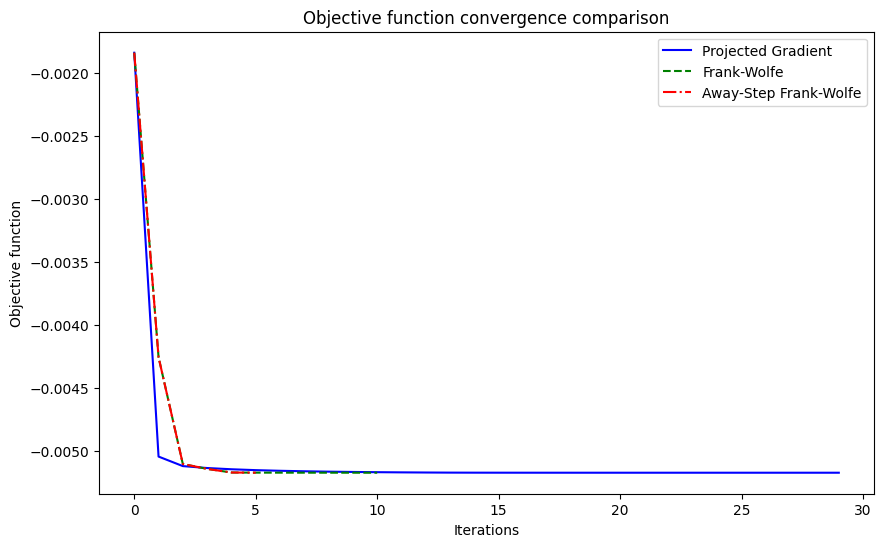

Processing:  EUROSTOXX50


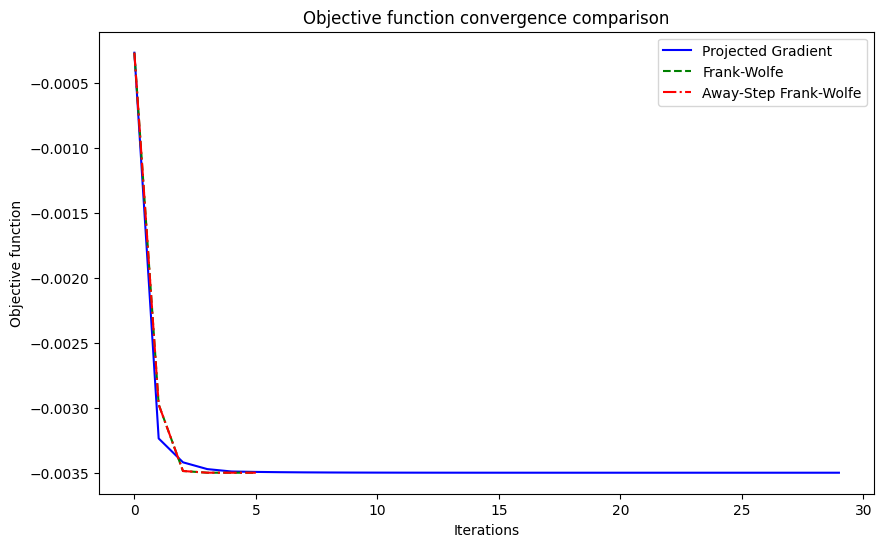

Processing:  FTSE_MIB


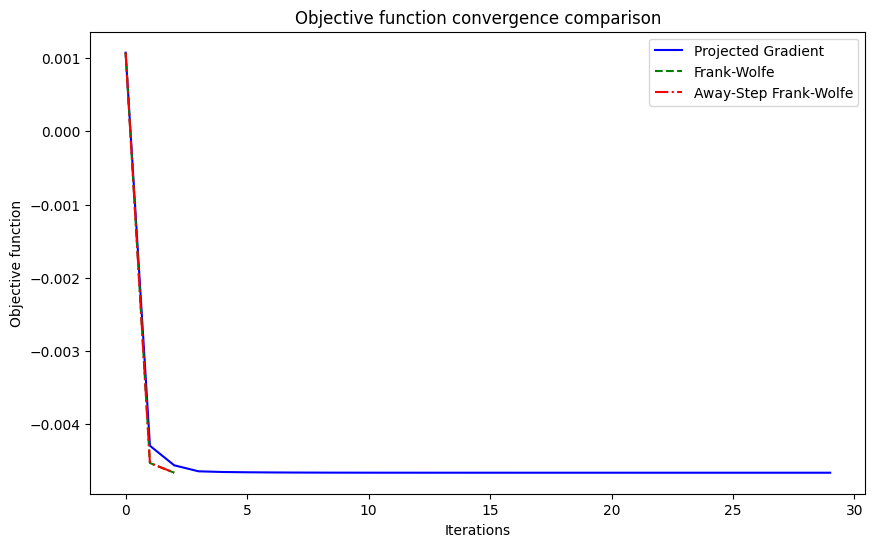

In [14]:
plot_pipeline_results(results_df_10)

In [ ]:
#results_df_10.to_pickle("./results_df_10_s130.pkl")

#shutil.make_archive('FTSE_MIB', 'zip', '.', 'FTSE_MIB')
#shutil.make_archive('FTSE100', 'zip', '.', 'FTSE100')
shutil.make_archive('EUROSTOXX50', 'zip', '.', 'EUROSTOXX50')
# Scaricare il file ZIP creato
files.download('EUROSTOXX50.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>